In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

In [38]:
data = np.array([0,1,2,3,4,5,6,7,8,9])      #       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
data[5]     # 5th position                          [5]
data[3:6]   # From 3rd to 5th position              [3, 4, 5]
data[:5]    # First 5                               [0, 1, 2, 3, 4]
data[5:]    # Without the first 5 (From 6th one)    [5, 6, 7, 8, 9]
data[-4]    # Fourth from behind                    [6]
data[::2]   # Every Second                          [0, 2, 4, 6, 8]
data[::-2]  # Every Second from behind              [9, 7, 5, 3, 1]
data[::-1]  # Reverse Order                         [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
np.dot([1,2,3], data[0:3][::-1])    #               Dot Product v^T * v

4

### AR(p) simulator

$X_t = c + \beta_1X_{t-1} + \beta_2X_{t-2} + ... + \beta_pX_{t-p} + \epsilon  \quad ,\epsilon \sim \mathcal{N}(0, \sigma^2)$

In [3]:
def sample_ar_process(n_samples, ar_params, noise_std = 1.0, initial_values = None):
    p = len(ar_params)

    if initial_values is None:
        initial_values = np.zeros(p)
    
    # Initial data with zero's
    data = np.zeros(n_samples)
    # First p values
    data[:p] = initial_values

    # Generate AR(p) process:
    for i in range(p, n_samples):
        noise = np.random.normal(0, noise_std)
        data[i] = np.dot(ar_params, data[i-p:i][::-1]) + noise
    return data
    

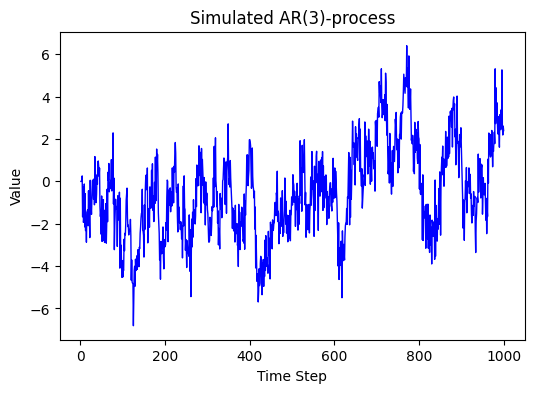

In [4]:
ar_data = sample_ar_process(n_samples = 1000, ar_params = np.array([0.33, 0.5, 0.1]))
ar_data = np.array([np.arange(1,len(ar_data)+1),ar_data])
plt.figure(figsize=(6,4))
plt.plot(ar_data[0], ar_data[1], linewidth = 1, color ='blue')
plt.title("Simulated AR(3)-process")
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.show()

### SDE Simulator

$dX_t = a(X_t, t)dt + b(X_t, t)dW_t \\$

$a(X_t, t)$: Drift parameter $\\$
$b(X_t, t)$: Diffusion parameter $\\$
$W_t$: Wiener Process (Brownian motion)

To simulate data we use the **Euler-Maruyama Method**.

$X_t = X_{t-1} + a(X_{t-1}, t-1)\Delta t + b(X_{t-1}, t-1)\Delta W_{t-1} \quad \Delta W \sim \mathcal{N}(0, \Delta t)$

In [5]:
# Drift function
def a(X, t):
    return 0.2 * X
# Diffusion function
def b(X, t):
    return 0.3

def euler_maruyama(n_samples, delta_t, a, b, X0):
    X = np.zeros(n_samples)
    X[0] = X0
    for t in range(1, n_samples):
        # Wiener process
        W = np.random.normal(0, np.sqrt(delta_t))
        X[t] = X[t-1] + a(X[t-1], t*delta_t)*delta_t + b(X[t-1], t*delta_t)*W

    return X



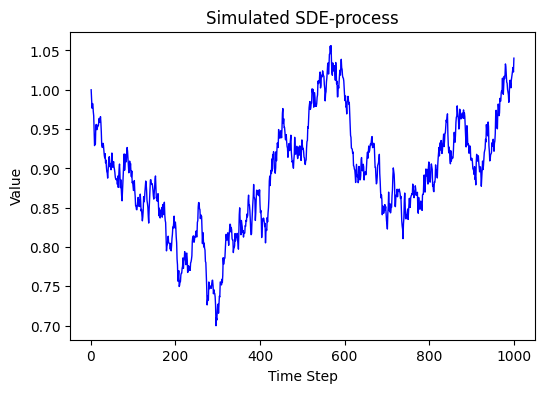

In [6]:
sde_data = euler_maruyama(n_samples = 1000, delta_t = 0.001, a = a, b = b, X0 = 1)
sde_data = np.array([np.arange(1,len(sde_data)+1),sde_data])
plt.figure(figsize=(6,4))
plt.plot(sde_data[0], sde_data[1], linewidth = 1, color ='blue')
plt.title("Simulated SDE-process")
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.show()

### Preprocess Data (Creating State-Action pairs)

- **State:** Window of consequtive values from time series.
- **Action:** Next value in the time series.

- **Window size:** 10

In [7]:
def state_action_pairs(data, window):
    states = []
    actions = []

    for i in range(len(data)-window):
        state = data[i:i+window]
        action = data[i+window]
        states.append(state)
        actions.append(action)
    
    return np.array(states), np.array(actions)

states, actions = state_action_pairs(sde_data[1], window=10)

# for i in range(3):
#     print(f"State {i}: {states[i]}")
#     print(f"Action {i}: {actions[i]}")
#     print("")

### S5 JAX framework to train the policy network

In [17]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from sklearn.model_selection import train_test_split

State Action Dataset

In [27]:
class StateActionDataset:
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]


# Split data into training and validation sets
train_states, val_states, train_actions, val_actions = train_test_split(states, actions, test_size=0.2, random_state=42)

train_dataset = StateActionDataset(train_states, train_actions)
val_dataset = StateActionDataset(val_states, val_actions)

train_s = jnp.array(train_states)
train_a = jnp.array(train_actions)
val_s = jnp.array(val_states)
val_a = jnp.array(val_actions)

S5 Framework

In [21]:
# Define the S5 layer
class S5Layer(nn.Module):
    input_dim: int
    output_dim: int

    def setup(self):
        self.W = self.param('W', nn.initializers.xavier_uniform(), (self.input_dim, self.output_dim))
        self.b = self.param('b', nn.initializers.zeros, (self.output_dim,))

    # Forward pass of the layer
    def __call__(self, x):
        return jnp.dot(x, self.W) + self.b

# Define the S5 block
class S5Block(nn.Module):
    input_dim: int
    output_dim: int

    def setup(self):
        self.s5_layer = S5Layer(self.input_dim, self.output_dim)
        self.norm = nn.LayerNorm()
        self.dropout = nn.Dropout(0.1)

    def __call__(self, x, train: bool = True):
        x = self.s5_layer(x)
        x = jnn.relu(x)
        x = self.norm(x)
        x = self.dropout(x, deterministic=not train)
        return x

# Define the full S5 model
class S5Model(nn.Module):
    input_dim: int
    output_dim: int
    num_layers: int

    def setup(self):
        self.layers = [S5Block(self.input_dim, self.output_dim) for _ in range(self.num_layers)]

    def __call__(self, x, train: bool = True):
        for layer in self.layers:
            x = layer(x, train)
        return x


In [23]:
print(x)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [22]:
# Initialize the model
input_dim = 10  # Number of features in state
output_dim = 1  # Number of features in action
num_layers = 3
model = S5Model(input_dim, output_dim, num_layers)

# Create a random input tensor for initialization
x = jnp.ones((2, input_dim))  # [batch_size, feature_dimension]

# Initialize parameters
rng = jax.random.PRNGKey(0)
params = model.init(rng, x, train=True)

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (10,).

Training the policy network

In [ ]:
# Define the loss function
def mse_loss(params, model, x, y):
    preds = model.apply(params, x, train=True)
    return jnp.mean((preds - y) ** 2)

# Initialize the training state
tx = optax.adam(learning_rate=0.001)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Training step
@jax.jit
def train_step(state, x, y):
    loss, grads = jax.value_and_grad(mse_loss)(state.params, model, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Training loop
num_epochs = 100
batch_size = 32

def data_generator(states, actions, batch_size):
    indices = np.arange(len(states))
    np.random.shuffle(indices)
    for start_idx in range(0, len(states) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield states[excerpt], actions[excerpt]

for epoch in range(num_epochs):
    for batch_states, batch_actions in data_generator(train_states, train_actions, batch_size):
        batch = (jnp.array(batch_states), jnp.array(batch_actions))
        state, loss = train_step(state, batch[0], batch[1])

    # Compute loss on validation set
    val_loss = mse_loss(state.params, model, jnp.array(val_states), jnp.array(val_actions))
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')
